In [33]:
import xpress as xp
import numpy as np
import pandas as pd
import time

In [34]:
print("Loading Data")
# Load distance matrix
distance_matrix = np.loadtxt('distance_matrix_reduce2.csv', delimiter=',')
stations = pd.read_csv('candidate_stations_P300_kmeans_no_snap.csv')
pois = pd.read_csv('reduced_pois2.csv')
existing_station_data=pd.read_csv('station_data.csv')

demand_file=pd.read_csv('poi_demand_per_hour_type_commercial_cluster0.csv') 


Loading Data


In [35]:
# determining the station category base on the closest poi category 
poi_categories = pois['category']

min_row_idx_for_station = np.argmin(distance_matrix, axis=0)

# Assign each station the category of the closest POI
station_categories = poi_categories.iloc[min_row_idx_for_station].reset_index(drop=True)


stations['category'] = station_categories.values


pd.unique(station_categories)

array(['library', 'residential', 'school', 'commercial', 'university',
       'hospital'], dtype=object)

In [36]:
C = ['library', 'residential', 'school', 'commercial', 'university', 'hospital']

# Dictionary mapping each category to list of POI indices
I_c = {
    c: pois.index[pois['category'] == c].tolist()
    for c in C
}

# Assign guaranteed service levels (fraction of demand to serve)
w_c = {
    'library': 0.8,       # 80% of library POI demand must be served
    'residential': 0.75,  # 75% of residential POI demand must be served
    'school': 0.85,       # 85% of school POI demand must be served
    'commercial': 0.9,    # 90% of commercial POI demand must be served
    'university': 0.95,   # 95% of university POI demand must be served
    'hospital': 0.98      # 98% of hospital POI demand must be served
}


In [37]:
capacity_map = dict(zip(existing_station_data['station_id'], existing_station_data['capacity']))

# Create the vector: for each snapped_station_id, get capacity if present or 0.
capacity_vector = [
    capacity_map.get(sid, 10)
    for sid in stations['snapped_station_id']
]


In [38]:
I = distance_matrix.shape[0]  # Number of POIs (demand points)
J = distance_matrix.shape[1] # Number of candidate stations


demand = [demand_file.iloc[i]['demand_per_hour'] for i in range(len(demand_file))]
demand = demand_file['demand_per_hour'].tolist()

In [39]:
k=1000
Tau=0.8

In [40]:
# Parameters
Cost_existing_commercial = 70000   # £ to reopen existing station (B)
Cost_existing = 60000

Cost_new = 90000         # £ to build new station (A)
Cost_new_commercial=80000


In [41]:
cost_vector = np.where(
    (stations['is_existing_station']) & (stations['category'] == 'commercial'), 
    Cost_existing_commercial,
    np.where(
        (stations['is_existing_station']) & (stations['category'] != 'commercial'), 
        Cost_existing,
        np.where(
            (~stations['is_existing_station']) & (stations['category'] == 'commercial'), 
            Cost_new_commercial,
            Cost_new
        )
    )
)


In [42]:
print("DEFINE MODEL PARAMETERS")
# IMPORTANT: Set the number of facilities to locate
# p =   379 # Change this to test different scenarios

print(f"\n{'='*70}")
print(f"MODEL PARAMETERS")
print(f"{'='*70}")
print(f"Number of POIs (I):                {I}")
print(f"Number of candidate stations (J):  {J}")

DEFINE MODEL PARAMETERS

MODEL PARAMETERS
Number of POIs (I):                885
Number of candidate stations (J):  379


In [43]:
print("CREATE XPRESS PROBLEM")
prob = xp.problem(name='p_centre_reduce')

CREATE XPRESS PROBLEM


/var/folders/tn/v19h6ld131n5p0bkj6b850sr0000gn/T/ipykernel_49723/926094487.py:2: LicenseWarning: Using the license file found in your Xpress installation. If you want to use this license and no longer want to see this message, use the following code before using the xpress module:
  xpress.init('/Applications/FICO Xpress/xpressmp/bin/xpauth.xpr')
  prob = xp.problem(name='p_centre_reduce')


In [44]:
print("="*70)
print("DEFINE DECISION VARIABLES")
print("="*70)
# Y[j] = 1 if facility j is opened, 0 otherwise
Y = {j: prob.addVariable(vartype=xp.binary, name=f'Y_{j}') for j in range(J)}

# X[i,j] = 1 if demand point i is assigned to station j, 0 otherwise
X = {(i, j): prob.addVariable(vartype=xp.binary, name=f'X_{i}_{j}') 
     for i in range(I) for j in range(J)}

Z = {j: prob.addVariable(vartype=xp.integer, name=f'Z_{j}') for j in range(J)}

Budget = prob.addVariable(name='Budget', lb=0)


# Q = maximum service distance (minimax objective)
Q = prob.addVariable(name='Q', lb=0)

print(f"Created {J} Y variables (station selection)")
print(f" Created {I*J:,} X variables (POI-station assignments)")
print(f" Created 1 Q variable (minimax distance)")
print(f"  Total variables: {J + I*J + 1:,}")


DEFINE DECISION VARIABLES
Created 379 Y variables (station selection)
 Created 335,415 X variables (POI-station assignments)
 Created 1 Q variable (minimax distance)
  Total variables: 335,795


In [45]:
print("="*70)
print("ADD CONSTRAINTS")
print("="*70)
# CONSTRAINT 1: Each POI must be assigned to exactly one station
print("  Adding constraint 1: POI assignment (each POI assigned to exactly one station)...")
for i in range(I):
    prob.addConstraint(xp.Sum(X[i, j] for j in range(J)) <= 1)

# # CONSTRAINT 2: Exactly p stations must be opened
# print(f"  Adding constraint 2: Facility count (open exactly {p} stations)...")
# prob.addConstraint(xp.Sum(Y[j] for j in range(J)) <= p)

# CONSTRAINT 3: Assignment only to open stations (linking constraints)
print("  Adding constraint 3: Linking constraints (assign only to open stations)...")
for i in range(I):
    for j in range(J):
        prob.addConstraint(X[i, j] <= Y[j])

# CONSTRAINT 4: Minimax distance constraint
print("  Adding constraint 4: Minimax distance (Q >= distance to assigned station)...")
for i in range(I):
    prob.addConstraint(xp.Sum(distance_matrix[i, j] * X[i, j] for j in range(J)) <= Q)

# CONSTRAINT 5: BUDGET CONSTRAIN
prob.addConstraint(xp.Sum(cost_vector[j] * Y[j] for j in range(J)) + k * xp.Sum((Z[j] - capacity_vector[j] * Y[j]) for j in range(J)) <= 45000000.0)


ADD CONSTRAINTS
  Adding constraint 1: POI assignment (each POI assigned to exactly one station)...
  Adding constraint 3: Linking constraints (assign only to open stations)...
  Adding constraint 4: Minimax distance (Q >= distance to assigned station)...


In [46]:
for j in range(J):
    prob.addConstraint(Z[j] >= capacity_vector[j]*Y[j])
    prob.addConstraint(Z[j] <= 100 * Y[j])
    prob.addConstraint(xp.Sum(X[i, j] * demand[i] for i in range(I)) <= Tau*Z[j])



In [55]:
for c in C:
    indices = I_c[c]  # POI indices for category c
    lhs = xp.Sum(X[i, j] * demand[i] for i in indices for j in range(J))
    rhs = w_c[c] * xp.Sum(demand[i] for i in indices)  # Replace with correct right-hand side
    prob.addConstraint(lhs >= rhs)


In [56]:
print("="*70)
print("SET OBJECTIVE FUNCTION")
print("="*70)
# # Minimize Q (the maximum service distance)
prob.setObjective(Q, sense=xp.minimize)

SET OBJECTIVE FUNCTION


In [57]:
print("\n" + "="*70)
print("SOLVING MODEL...")
print("="*70 + "\n")

start_solve = time.time()

# Solve the problem
xp.setOutputEnabled(True)
prob.solve()

solve_time = time.time() - start_solve


SOLVING MODEL...

FICO Xpress v9.7.0, Hyper, solve started 9:19:12, Nov 22, 2025
Heap usage: 220MB (peak 220MB, 71MB system)
Minimizing MILP p_centre_reduce using up to 8 threads and up to 8192MB memory, with these control settings:
OUTPUTLOG = 1
NLPPOSTSOLVE = 1
XSLP_DELETIONCONTROL = 0
XSLP_OBJSENSE = 1
Original problem has:
    338329 rows       336175 cols      2016019 elements    336173 entities
Presolved problem has:
    338325 rows       336172 cols      2016009 elements    336171 entities
LP relaxation tightened
Presolve finished in 11 seconds
Heap usage: 428MB (peak 580MB, 71MB system)

Coefficient range                    original                 solved        
  Coefficients   [min,max] : [ 4.29e-06,  8.00e+04] / [ 1.34e-07,  2.00e+00]
  RHS and bounds [min,max] : [ 4.53e-01,  4.50e+07] / [ 9.05e-01,  7.03e+02]
  Objective      [min,max] : [ 1.00e+00,  1.00e+00] / [ 8.00e+00,  8.00e+00]
Autoscaling applied standard scaling

Will try to keep branch and bound tree memory usag

In [59]:
    print("\n" + "="*70)
    print("SOLUTION SUMMARY")
    print("="*70)
    

    # Extract optimal minimax distance
    Q_optimal = prob.getSolution(Q)
    
    # Extract which stations to open
    stations_open = []
    for j in range(J):
        if prob.getSolution(Y[j]) > 0.5:  # Binary variable, so > 0.5 means 1
            stations_open.append(j)

    # Classify as existing or new
    existing_open = [j for j in stations_open if cost_vector[j] == Cost_existing]
    new_open = [j for j in stations_open if cost_vector[j] == Cost_new]
    print(existing_open)
    
    # Calculate total cost
    total_cost = sum(cost_vector[j] for j in stations_open)
    



SOLUTION SUMMARY
[12, 54, 95, 120, 131, 300, 301, 302, 303, 304, 307, 308, 309, 310, 311, 312, 313, 314, 315, 317, 318, 319, 321, 323, 324, 325, 327, 328, 329, 330, 331, 333, 334, 335, 337, 338, 339, 341, 342, 345, 346, 347, 348, 349, 352, 353, 354, 355, 356, 358, 361, 362, 363, 364, 367, 368, 369, 372, 373, 374, 375, 377]


In [60]:

# Extract Z solution as a dictionary: {station index: value}
Z_solution = {j: prob.getSolution(Z[j]) for j in range(J)}

In [61]:
print(f"\n{'='*70}")
print(f"OPTIMAL P-CENTRE RESULTS")
print(f"{'='*70}")

print(f"\n1. STATIONS TO OPEN ({len(stations_open)} out of {J}):")
print(f"   Station indices: {stations_open}")

print(f"\n   Station details:")
optimal_stations_list = []
for idx, j in enumerate(stations_open, 1):
    station_id = stations.iloc[j]['candidate_id']
    lat = stations.iloc[j]['centroid_lat']
    lon = stations.iloc[j]['centroid_lon']
    num_docks = int(Z_solution[j]) 
    new_dock = num_docks - capacity_vector[j]
    optimal_stations_list.append({
        'index': j,
        'rank': idx,
        'station_id': station_id,
        'latitude': lat,
        'longitude': lon,
        'num_docks': num_docks,
        'new_dock' : new_dock
    })

    print(f"   {idx:2d}. (Station ID = {station_id}) | Docks to open: {num_docks} | Dock to construct: {new_dock}" )

print(f"\n2. OPTIMAL MINIMAX DISTANCE:")
print(f"   Maximum service distance (Q*) = {Q_optimal:.4f} km")
print(f"   All {I:,} POIs served within {Q_optimal:.4f} km of nearest station")



OPTIMAL P-CENTRE RESULTS

1. STATIONS TO OPEN (379 out of 379):
   Station indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204,

In [62]:
budget_value = sum(
    cost_vector[j] * prob.getSolution(Y[j]) for j in range(J)
) + 1000 * sum(
    prob.getSolution(Z[j]) - capacity_vector[j] * prob.getSolution(Y[j]) for j in range(J)
)
print(f"Budget used: {budget_value} | (Q*) = {Q_optimal:.4f} km | STATIONS TO OPEN ({len(stations_open)} out of {J}) ")

Q_value_graph = []
Budget_value_graph=[]

Budget_value_graph.append(budget_value)
Q_value_graph.append(Q_optimal)

# Lists to store per-iteration results
dock_details_per_budget = []

while budget_value >= 90000:
    Budget= budget_value - 100000

    prob.addConstraint(xp.Sum(cost_vector[j] * Y[j] for j in range(J)) + k * xp.Sum((Z[j] - capacity_vector[j] * Y[j]) for j in range(J)) <= Budget)

    
    xp.setOutputEnabled(False)
    prob.solve()

    budget_value = sum(
    cost_vector[j] * prob.getSolution(Y[j]) for j in range(J)
    ) + 1000 * sum(
        prob.getSolution(Z[j]) - capacity_vector[j] * prob.getSolution(Y[j]) for j in range(J)
    )

    Budget_value_graph.append(budget_value)

    Q_optimal = prob.getSolution(Q)

    Q_value_graph.append(Q_optimal)

    stations_open = []
    for j in range(J):
        if prob.getSolution(Y[j]) > 0.5:  # Binary variable, so > 0.5 means 1
            stations_open.append(j)

     # After solving, collect station details for this budget iteration
    station_details = []
    for idx, j in enumerate(stations_open, 1):
        station_id = stations.iloc[j]['candidate_id']
        lat = stations.iloc[j]['centroid_lat']
        lon = stations.iloc[j]['centroid_lon']
        num_docks = int(Z_solution[j])                  # Z_solution = [prob.getSolution(Z[j]) for j in range(J)]
        new_dock = num_docks - capacity_vector[j]        # How many docks were added
        station_details.append({
            'budget': budget_value,
            'station_index': j,
            'rank': idx,
            'station_id': station_id,
            'latitude': lat,
            'longitude': lon,
            'num_docks': num_docks,
            'new_dock': new_dock
        })
    
    dock_details_per_budget.append(station_details) 
    
    print(f"Budget used: {budget_value} | (Q*) = {Q_optimal:.4f} km | STATIONS TO OPEN ({len(stations_open)} out of {J}) ")

Budget used: 44994000.0 | (Q*) = 0.4070 km | STATIONS TO OPEN (379 out of 379) 
Budget used: 29880000.0 | (Q*) = 0.4070 km | STATIONS TO OPEN (366 out of 379) 
Budget used: 22350000.0 | (Q*) = 0.4070 km | STATIONS TO OPEN (274 out of 379) 
Budget used: 22250000.0 | (Q*) = 0.4070 km | STATIONS TO OPEN (277 out of 379) 
Budget used: 7660000.0 | (Q*) = 0.4070 km | STATIONS TO OPEN (94 out of 379) 
Budget used: 7557000.0 | (Q*) = 0.4070 km | STATIONS TO OPEN (95 out of 379) 
Budget used: 7434000.0 | (Q*) = 0.4070 km | STATIONS TO OPEN (91 out of 379) 
Budget used: 7310000.0 | (Q*) = 0.4070 km | STATIONS TO OPEN (90 out of 379) 
Budget used: 7190000.0 | (Q*) = 0.4070 km | STATIONS TO OPEN (87 out of 379) 
Budget used: 7090000.0 | (Q*) = 0.4070 km | STATIONS TO OPEN (90 out of 379) 
Budget used: 6940000.0 | (Q*) = 0.4070 km | STATIONS TO OPEN (85 out of 379) 
Budget used: 6840000.0 | (Q*) = 0.4070 km | STATIONS TO OPEN (85 out of 379) 
Budget used: 6700000.0 | (Q*) = 0.4070 km | STATIONS TO 

ModelError: Solution is not available

In [ ]:
dock_details_per_budget

[]

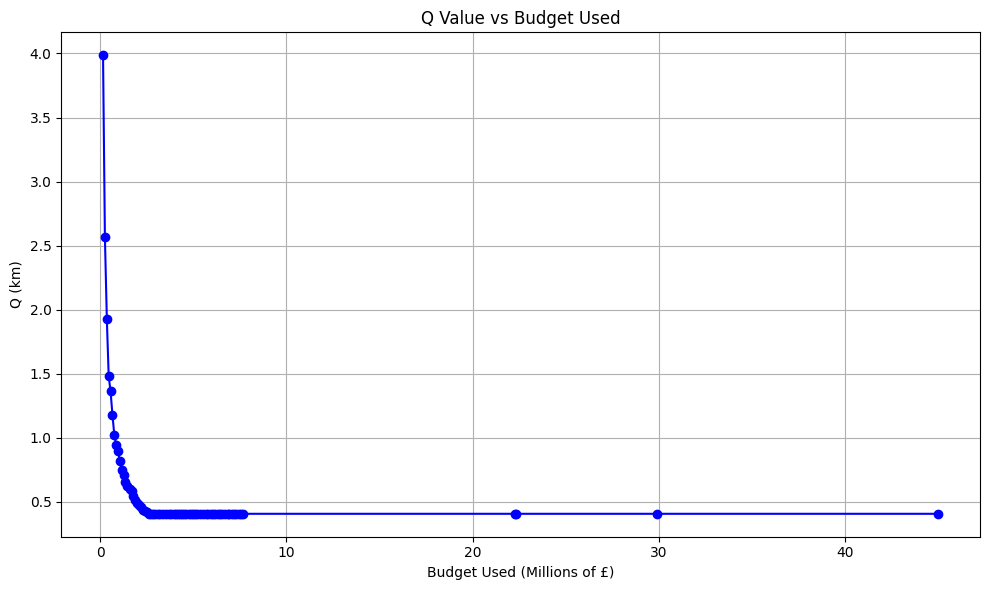

In [83]:
Budget_value_graph = np.array(Budget_value_graph)
Q_value_graph = np.array(Q_value_graph)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(np.array(Budget_value_graph)/1_000_000, Q_value_graph, marker='o', linestyle='-', color='blue')
plt.xlabel('Budget Used (Millions of £)')
plt.ylabel('Q (km)')
plt.title('Q Value vs Budget Used')
plt.grid(True)
plt.tight_layout()
plt.show()



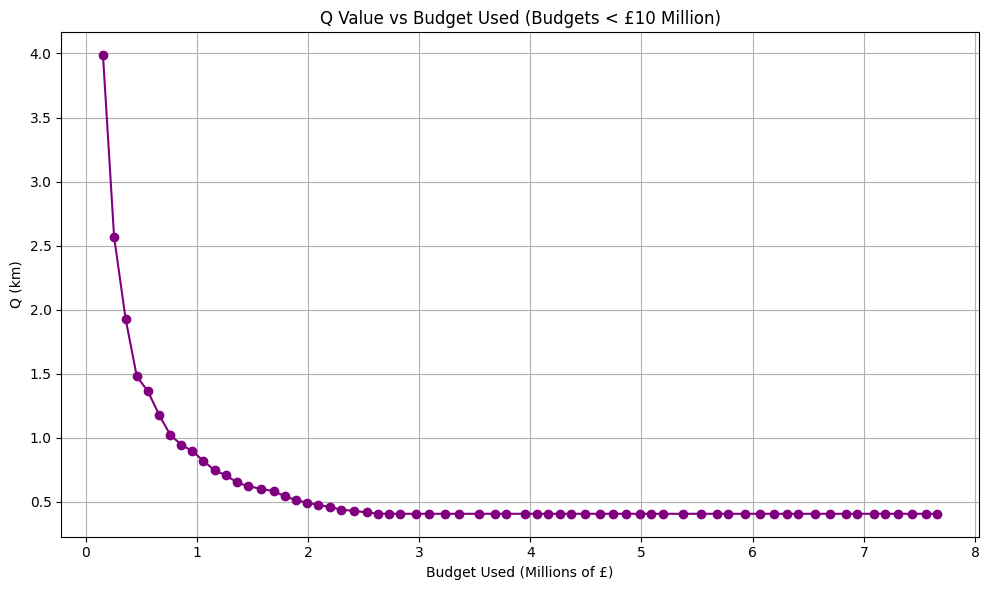

In [82]:
# Filter for budgets less than 10 million
filter_mask = Budget_value_graph < 10_000_000
Q_filtered = Q_value_graph[filter_mask]
Budget_filtered = Budget_value_graph[filter_mask]

plt.figure(figsize=(10, 6))
plt.plot(Budget_filtered / 1_000_000, Q_filtered, marker='o', linestyle='-', color='purple')
plt.xlabel('Budget Used (Millions of £)')
plt.ylabel('Q (km)')
plt.title('Q Value vs Budget Used (Budgets < £10 Million)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
sol = {(i, j): prob.getSolution(X[i, j]) for i in range(I) for j in range(J)}
solution_matrix = np.zeros((I, J))
for (i, j), val in sol.items():
     solution_matrix[i, j] = val
assignments = np.argmax(solution_matrix, axis=1)

# # Calculate metrics
# total_demand = demand.sum()
# demand_satisfied = sum(demand[assignments == j] for j in stations_open)
    
# selected_capacity = sum(stations.iloc[j]['capacity'] for j in stations_open)
# avg_utilization = 100 * demand_satisfied / selected_capacity if selected_capacity > 0 else 0
all_distances = [distance_matrix[i, assignments[i]] for i in range(I)]
mean_distance = np.mean(all_distances)


KeyboardInterrupt: 

In [ ]:
    w = []
    for j in range(J):
        dock_added = max(0, Z_solution[j] - capacity_vector[j])  # only count positive dock additions
        w.append(dock_added)

    dock_cost = sum(w) * 1000  # replace 1000 with actual cost per dock if different

    total_cost = existing_cost + new_cost + dock_cost  # make sure existing_cost and new_cost defined earlier

    print(f"\n1. OPTIMAL MINIMAX DISTANCE:")
    print(f"   Q* = {Q_optimal:.4f} km")

    print(f"\n2. STATIONS OPENED: {len(stations_open)} total")
    print(f"   ├─ Existing (reopen): {len(existing_open)} stations")
    print(f"   └─ New (build): {len(new_open)} stations")

    print(f"\n3. COST BREAKDOWN:")
    print(f"   Reopen existing: {len(existing_open)} × £{COST_REOPEN_EXISTING:,} = £{existing_cost:,}")
    print(f"   Build new:      {len(new_open)} × £{COST_BUILD_NEW:,} = £{new_cost:,}")
    print(f"   Dock cost:      £{dock_cost:,}")
    print(f"   Total cost:     £{total_cost:,}")
    print(f"   Budget used:    {100 * total_cost / BUDGET:.1f}% of £{BUDGET:,}")
    print(f"   Remaining:      £{BUDGET - total_cost:,}")

    
    print(f"\n4. STATIONS TO REOPEN :")
    for j in sorted(existing_open):
        cost = cost_vector[j]
        pois_count = (assignments == j).sum()
        print(f"   [{j:2d}] {str(stations.iloc[j]['candidate_id']):30s} | Cost: £{cost:,} | Serves {pois_count:,} POIs")

    print(f"\n6. STATIONS TO BUILD :")
    for j in sorted(new_open):
        cost = cost_vector[j]
        pois_count = (assignments == j).sum()
        lat, lon = stations.iloc[j]['centroid_lat'], stations.iloc[j]['centroid_lon']
        print(f"   [{j:2d}] Location ({lat:.4f}, {lon:.4f}) | Cost: £{cost:,} | Serves {pois_count:,} POIs")

In [ ]:
import folium
from folium import Circle, PolyLine

# Base map centered on the city
map_center = (pois['lat'].mean(), pois['lon'].mean())
m = folium.Map(location=map_center, zoom_start=13)

for station_idx in stations_open:
    # Station coordinates
    station_lat = stations.iloc[station_idx]['centroid_lat']
    station_lon = stations.iloc[station_idx]['centroid_lon']
    
    # POIs served by this station
    served_pois = [i for i, j in enumerate(assignments) if j == station_idx]
    
    # Calculate maximum coverage radius in kilometers
    if served_pois:
        max_distance_km = max(distance_matrix[i, station_idx] for i in served_pois)
    else:
        max_distance_km = 0.1  # small circle if no POIs
    
    # Draw station marker with Font Awesome bicycle icon
    folium.Marker(
        location=(station_lat, station_lon),
        popup=f"Station {stations.iloc[station_idx]['candidate_id']}",
        icon=folium.Icon(color='darkgreen', icon='bicycle', prefix='fa')
    ).add_to(m)
    
    # Draw transparent coverage circle around station
    Circle(
        location=(station_lat, station_lon),
        radius=max_distance_km * 1000,  # meters
        color='blue',
        fill=True,
        fill_opacity=0.1,
        weight=2,
        popup=f"Coverage area: {max_distance_km:.2f} km"
    ).add_to(m)
    
    # Draw lines and markers for each POI served by this station
    for poi_idx in served_pois:
        poi_lat = pois.iloc[poi_idx]['lat']
        poi_lon = pois.iloc[poi_idx]['lon']
        
        # Draw POI marker as a small red circle
        folium.CircleMarker(
            location=(poi_lat, poi_lon),
            radius=5,
            weight=3,
            color='brown',
            fill=True,
            fill_opacity=100,
            popup=f"POI {pois.iloc[poi_idx]['poi_id']}"
        ).add_to(m)
        
        # Draw line connecting station to POI
        line_coords = [(station_lat, station_lon), (poi_lat, poi_lon)]
        PolyLine(line_coords, color='black', weight=3, opacity=0.7).add_to(m)

# Save map to HTML file
m.save('stations_with_lines_map.html')
print("Map saved as stations_with_lines_map.html")
